<a href="https://colab.research.google.com/github/Joao-Girotto/Desafio-Python-Marvel/blob/joao/Desafio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalações

In [1]:
!pip install dotenv

## Importações

In [19]:
import requests
import hashlib
import os
import time
import pandas as pd
import sqlite3
import json
from dotenv import load_dotenv
from google.colab import userdata
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import regex as re

## Pegando as chaves

In [34]:
# load_dotenv()
# PUBLIC_KEY = os.getenv("Public_Key")
# PRIVATE_KEY = os.getenv("Private_Key")

PRIVATE_KEY = userdata.get("Private_Key")
PUBLIC_KEY = userdata.get("Public_Key")


## Endpoints e Parâmetros

In [35]:
ts = str(time.time())
to_hash = ts + PRIVATE_KEY + PUBLIC_KEY
hash_md5 = hashlib.md5(to_hash.encode()).hexdigest()

endCharacters = "https://gateway.marvel.com/v1/public/characters"
endComics = "https://gateway.marvel.com/v1/public/comics"
endSeries = "https://gateway.marvel.com/v1/public/series"
endCreators = "https://gateway.marvel.com/v1/public/creators"
endEvents = "https://gateway.marvel.com/v1/public/events"
endStories = "https://gateway.marvel.com/v1/public/stories"


params = {
    "apikey": PUBLIC_KEY,
    "ts": ts,
    "hash": hash_md5,
    "limit": 10
}


## Pegando o total de requisições

In [39]:
totalCharacters = requests.get(endCharacters, params=params)
totalCharacters = totalCharacters.json()
total = totalCharacters['data']['total']

totalEvents = requests.get(endEvents, params=params)
totalEvents = totalEvents.json()
totalE = totalEvents['data']['total']

totalCreators = requests.get(endCreators, params=params)
totalCreators = totalCreators.json()
totalC = totalCreators['data']['total']

totalSeries = requests.get(endSeries, params=params)
totalSeries = totalSeries.json()
totalSe = totalSeries['data']['total']

totalComics = requests.get(endComics, params=params)
totalComics = totalComics.json()
totalCo = totalComics['data']['total']

totalStories = requests.get(endStories, params=params)
totalStories = totalStories.json()
totalSt = totalStories['data']['total']

totalSe

15707

## Função para realizar requisições

In [31]:

def requisition(endpoint, total, step, limit, params_base=None):
    data_array = []
    offset = 0

    if params_base is None:
        params_base = {}

    while offset <= total:
        params = params_base.copy()
        params['offset'] = offset
        params['limit'] = limit

        response = requests.get(endpoint, params=params)

        if response.status_code != 200:
            print(f"Erro no offset {offset}: status code {response.status_code}")
            offset += step
            continue

        try:
            data = response.json()
        except ValueError:
            print(f"Erro ao converter JSON no offset {offset}")
            offset += step
            continue

        if not data or 'data' not in data or 'results' not in data['data']:
            print(f"Resposta inesperada ou vazia no offset {offset}")
            offset += step
            continue

        data_array.extend(data['data']['results'])
        print(f"Offset: {offset} | Status: {response.status_code}")
        offset += step

    df = pd.DataFrame(data_array)
    return df

## Conversão para CSV

In [38]:
def create_csv(df, nome_arquivo):  # Já estava praticamente correta

    try:
        df.to_csv(nome_arquivo, index=False, encoding='utf-8')
    except Exception as e:
        print(f'Error when creating the file {nome_arquivo}: {e}')

## Chamando as requisições

In [ ]:
df_characters = requisition(endCharacters, total, step=100, limit=100, params_base=params)
create_csv(df_characters, 'Characters.csv')

# Events
df_events = requisition(endEvents, totalE, step=10, limit=10, params_base=params)
create_csv(df_events, 'Events.csv')

# Creators
df_creators = requisition(endCreators, totalC, step=100, limit=100,  params_base=params)
create_csv(df_creators, 'Creators.csv')

## Realizando Converções

In [ ]:
df_characters = df_characters[['name', 'id', 'description', 'comics', 'thumbnail']]
df_events = df_events[['title', 'id', 'description', 'characters', 'creators', 'comics', 'start', 'end', 'modified']]
df_creators = df_creators[['id', 'firstName', 'middleName', 'lastName', 'fullName', 'suffix', 'thumbnail','comics', 'events', 'stories', 'series']]
df_characters['comics_available'] = df_characters['comics'].apply(lambda x: x.get('available'))
df_characters['comics_returned'] = df_characters['comics'].apply(lambda x: x.get('returned'))
df_characters['thumbnail_path'] = df_characters['thumbnail'].apply(lambda x: x.get('path'))
df_characters['comics'] = df_characters['comics'].apply(lambda x: json.dumps(x))
df_characters['thumbnail'] = df_characters['thumbnail'].apply(lambda x: json.dumps(x))
df_events['comics_available'] = df_events['comics'].apply(lambda x: x.get('available'))
df_events['comics_returned'] = df_events['comics'].apply(lambda x: x.get('returned'))
df_events['comics'] = df_events['comics'].apply(lambda x: json.dumps(x))
df_events['creators_available'] = df_events['creators'].apply(lambda x: x.get('available'))
df_events['creators'] = df_events['creators'].apply(lambda x: json.dumps(x))
df_events['characters_available'] = df_events['characters'].apply(lambda x: x.get('available'))
df_events['characters'] = df_events['characters'].apply(lambda x: json.dumps(x))
df_creators['comics_available'] = df_creators['comics'].apply(lambda x: x.get('available'))
df_creators['events_available'] = df_creators['events'].apply(lambda x: x.get('available'))
df_creators['stories_available'] = df_creators['stories'].apply(lambda x: x.get('available'))
df_creators['series_available'] = df_creators['series'].apply(lambda x: x.get('available'))
df_creators['thumbnail_path'] = df_creators['thumbnail'].apply(lambda x: x.get('path'))
df_creators['comics'] = df_creators['comics'].apply(lambda x: json.dumps(x))
df_creators['events'] = df_creators['events'].apply(lambda x: json.dumps(x))
df_creators['series'] = df_creators['series'].apply(lambda x: json.dumps(x))
df_creators['stories'] = df_creators['stories'].apply(lambda x: json.dumps(x))
df_creators['thumbnail'] = df_creators['thumbnail'].apply(lambda x: json.dumps(x))

## Salvando no Banco de Dados

In [ ]:
con = sqlite3.connect('Marvel.db')
df_characters.to_sql("characters", con, if_exists="replace", index=False)
df_events.to_sql("events", con, if_exists="replace", index=False)
df_creators.to_sql("creators", con, if_exists="replace", index=False)
con.close()

## Salvando Com funções em Banco de Dados

In [3]:
def query_db(query, params=None, db='Marvel.db'):
  try:
    with sqlite3.connect(db) as con:
      return pd.read_sql_query(query, con, params)

  except Exception as e:
    print(f'Erro com a database: {e}')
    return pd.DataFrame()

def series_add_db(df):  # Agora recebe um DataFrame

    def calculateDuration(row):
        return 999 if row['endYear'] == 2099 else row['endYear'] - row['startYear']

    def function_dict(x):
        creators = [item['name'] for item in x['items']] if isinstance(x, dict) and 'items' in x else []
        return ', '.join(creators)

    def amount(x):
        return x.get('available', 0)

    with sqlite3.connect('Marvel.db') as con:
        df['duration'] = df.apply(calculateDuration, axis=1)
        df['creator_name'] = df['creators'].apply(function_dict)
        df['character_qty'] = df['characters'].apply(amount)
        df['creator_qty'] = df['creators'].apply(amount)
        df['story_qty'] = df['stories'].apply(amount)
        df['event_qty'] = df['events'].apply(amount)
        df['comic_qty'] = df['comics'].apply(amount)

        df = df[['id', 'title', 'description', 'startYear', 'endYear',
                 'rating', 'type', 'duration', 'creator_name', 'creator_qty',
                 'character_qty', 'story_qty', 'event_qty', 'comic_qty']]

        df.to_sql("series", con, if_exists="append", index=False)

def comics_add_db(df):  # Agora recebe um DataFrame

    def funcao_series(x):
        return x.get('name', '') if isinstance(x, dict) else ''

    def funcao_price(x):
        if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict):
            return x[0].get('price', '')
        return ''

    with sqlite3.connect('Marvel.db') as con:
        df['price'] = df['prices'].apply(funcao_price)
        df['series_name'] = df['series'].apply(funcao_series)

        df = df[['id', 'digitalId', 'title', 'issueNumber', 'description',
                 'format', 'pageCount', 'series_name', 'price']]

        df.to_sql("comics", con, if_exists="append", index=False)



def stories_add_db(df):  # Agora recebe um DataFrame
    with sqlite3.connect('Marvel.db') as con:
        df = df[['id', 'title', 'description', 'type']]
        df.to_sql("stories", con, if_exists="append", index=False)

## Adicionando mais Endpoints ao Banco

In [40]:
df_series = requisition(endSeries, totalSe, step=100, limit=100, params_base=params)
create_csv(df_series, nome_arquivo='Series.csv')
series_add_db(df_series)

df_comics = requisition(endComics, total, step=100, limit=100, params_base=params)
create_csv(df_comics, nome_arquivo='Comics.csv')
series_add_db(df_comics)

df_stories = requisition(endStories, total, step=100, limit=100, params_base=params)
create_csv(df_stories, nome_arquivo='Stories.csv')
series_add_db(df_stories)


Offset: 0 | Status: 200
Offset: 100 | Status: 200
Offset: 200 | Status: 200
Offset: 300 | Status: 200
Offset: 400 | Status: 200
Offset: 500 | Status: 200
Offset: 600 | Status: 200
Offset: 700 | Status: 200
Offset: 800 | Status: 200
Offset: 900 | Status: 200
Offset: 1000 | Status: 200
Offset: 1100 | Status: 200
Offset: 1200 | Status: 200
Offset: 1300 | Status: 200
Offset: 1400 | Status: 200
Offset: 1500 | Status: 200
Offset: 1600 | Status: 200
Offset: 1700 | Status: 200
Offset: 1800 | Status: 200
Offset: 1900 | Status: 200
Offset: 2000 | Status: 200
Offset: 2100 | Status: 200
Offset: 2200 | Status: 200
Offset: 2300 | Status: 200
Offset: 2400 | Status: 200
Offset: 2500 | Status: 200
Offset: 2600 | Status: 200
Offset: 2700 | Status: 200
Offset: 2800 | Status: 200
Offset: 2900 | Status: 200
Offset: 3000 | Status: 200
Offset: 3100 | Status: 200
Offset: 3200 | Status: 200
Offset: 3300 | Status: 200
Offset: 3400 | Status: 200
Offset: 3500 | Status: 200
Offset: 3600 | Status: 200
Offset: 3700 

## Consultando o Banco de Dados

In [ ]:
con2 = sqlite3.connect('Marvel.db')

df2 = pd.read_sql_query("SELECT id, name, description, comics, comics_available, comics_returned FROM characters", con2)

query1 = """
SELECT SUBSTR(name, 1, 1) AS letra_inicial, COUNT(*) AS total_por_letra
FROM characters
GROUP BY letra_inicial
ORDER BY letra_inicial;
"""
query2 = """
SELECT id, name, comics_available
FROM characters
ORDER BY comics_available DESC
LIMIT 10;
"""

query3 = """
SELECT id, name, description, comics_available
FROM characters
WHERE description IS NOT NULL AND description != '';
"""

query3_1 = """
SELECT
  COUNT (*) FILTER (WHERE description IS NOT NULL AND description != '') AS com_descricao,
  COUNT (*) FILTER (WHERE description IS NULL OR description = '') AS sem_descricao
FROM characters;
"""

query4 = """
SELECT title, comics_available
FROM events
ORDER BY comics_available DESC
LIMIT 10;
"""

query5 = """
SELECT title,
       strftime('%d/%m/%Y', start) AS start_formatted,
       strftime('%d/%m/%Y', end) AS end_formatted,
       CAST((julianday(end) - julianday(start)) / 365.25 AS INTEGER) AS duration_in_years,
       comics_available
FROM events
WHERE julianday(start) <= julianday('2025-05-16') AND julianday(end) <= julianday('2025-05-16')
ORDER BY julianday(end) - julianday(start) DESC;
"""

query6 = """
SELECT title,
       strftime('%d/%m/%Y', SUBSTR(modified, 1, 10)) AS modified,
       strftime('%d/%m/%Y', start) AS start,
       strftime('%d/%m/%Y', end) AS end
FROM events
ORDER BY SUBSTR(modified, 1, 4) DESC;
"""

query7 = """
SELECT title, characters_available, comics_available
FROM events
ORDER BY characters_available DESC
LIMIT 10;
"""

query8 = """
SELECT title, characters_available, creators_available, comics_available
FROM events
WHERE characters_available > 0 AND creators_available > 0 AND comics_available > 0;
"""


query9 = """
SELECT  firstName, middleName, lastName, fullName, comics_available, events_available
FROM creators
ORDER BY comics_available DESC
LIMIT 15;
"""

query10 = """
SELECT
  COUNT(*) FILTER (WHERE thumbnail_path NOT LIKE '%image_not_available') AS Criadores_Com_Imagem_Associada,
  COUNT(*) FILTER (WHERE thumbnail_path LIKE '%image_not_available') AS Criadores_Sem_Imagem_Associada
FROM creators;
"""

query11 = """
SELECT
  COUNT(*) FILTER (WHERE thumbnail_path NOT LIKE '%image_not_available') AS Personagens_Com_Imagem_Associada,
  COUNT(*) FILTER (WHERE thumbnail_path LIKE '%image_not_available') AS Personagens_Sem_Imagem_Associada
FROM characters;
"""

count_letters = pd.read_sql_query(query1, con2)
most_comics_charatcers = pd.read_sql_query(query2, con2)
description_characters = pd.read_sql_query(query3, con2)
most_events_comics = pd.read_sql_query(query4, con2)
most_duration_events = pd.read_sql_query(query5, con2)
events_modified = pd.read_sql_query(query6, con2)
events_most_characters = pd.read_sql_query(query7, con2)
count_description = pd.read_sql_query(query3_1, con2)
comics_per_events = pd.read_sql_query(query9, con2)
creators_images = pd.read_sql_query(query10, con2)
characters_images = pd.read_sql_query(query11, con2)

con2.close()

# Funções Auxiliares

In [8]:
def plot_pie_charts(df, colors=None, figsize=(10, 6)):
    # Plotar os gráficos de pizza
    df_transposed = df.transpose()

    axes = df_transposed.plot.pie(
        subplots=True,
        autopct='%1.1f%%',
        figsize=figsize,
        legend=False,
        startangle=90,
        colors=colors
    )

    # Títulos e ajustes
    for ax, col in zip(axes, df_transposed.columns):
        ax.set_ylabel('')  # Remove rótulo do eixo Y
        ax.set_title(col, fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

def verify_first_letters(nome_completo):
  partes_nome = nome_completo.split()
  if len(partes_nome) >= 2:
    nome = partes_nome[0]
    sobrenome = partes_nome[-1] # Pega a última parte como sobrenome
    if nome and sobrenome: # Verifica se nome e sobrenome não são vazios
      return nome[0].lower() == sobrenome[0].lower()
  return False # Retorna False se não for possível verificar (nome curto ou vazio)

def plot_side_by_side_pies(series1, series2, titles=None, colors=None, figsize=(12, 6)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    series1.plot.pie(
        ax=axes[0],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        legend=False
    )

    series2.plot.pie(
        ax=axes[1],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        legend=False
    )

    if titles:
        axes[0].set_title(titles[0], fontsize=12, fontweight='bold')
        axes[1].set_title(titles[1], fontsize=12, fontweight='bold')

    axes[0].set_ylabel('')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()


def plot(dataframe ,title, x_label, y_label, grid='y', kind='bar', color='purple', rotation=90, show=True, **kwargs):
  ax = dataframe.plot(kind=kind, color=color, title=title, **kwargs)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  plt.xticks(rotation=rotation)
  plt.tight_layout()
  plt.grid(axis=grid)

  if show:
    plt.show()

  return ax

# Funções Series

## Função para analisar a quatidade de séries por ano

In [9]:
def series_by_year(dataframe, show_plot=False):
  series_year = dataframe[(dataframe['startYear'] > 0) & (dataframe['startYear'] < 2029)]['startYear'].value_counts().sort_index()

  if show_plot:
    plot(dataframe=series_year, title='Séries por Década', x_label='Década',
         y_label='Quantidade de Séries', figsize=(20, 6))

  return series_year

## Função para analisar a média de duração das séries

In [10]:
def series_average_duration(dataframe, show_plot=False):
  anos_series = dataframe[(dataframe['duration'] >= 0) &(dataframe['duration'] < 999)]['duration'].value_counts().sort_index().head(10) ## 999 definido para séries em produção

  if show_plot:
    plot(dataframe=anos_series, title='Series: Média da duração das series', x_label='Duração (anos)',
         y_label='Quantidade de séries')

  media = dataframe[(dataframe['duration'] >= 0) &(dataframe['duration'] < 999)]['duration'].mean() ## 999 definido para séries em produção
  return anos_series, media

## Função para analisar a distribuição das classificações

In [11]:
def series_distribution_rating(dataframe, show_plot=False):
  media = dataframe[dataframe['rating'] != '']['rating'].value_counts()

  if show_plot:
    plot(dataframe=media, x_label='Classificação etária', y_label='Quantidade de séries',
         title='Distribuição classificatória de faixa etária')

  return media

## Função para analisar a distribuição dos tipos

In [12]:
def series_distribuition_type(dataframe, show_plot=False):
  series_type = dataframe[dataframe['type'] != '']['type'].value_counts()

  if show_plot:
    plot(dataframe=series_type, x_label='Tipo', title='Distribuição dos tipos de séries',
         y_label='Quantidade de séries')

  return series_type

## Função para analisar a quantidade de personagens por ano

In [13]:
def series_quantity_characters_year(dataframe, show_plot=False):
  tempo = dataframe[(dataframe['character_qty'] > 0) & (dataframe['startYear'] > 1900) & (dataframe['startYear'] < 2029)].groupby('startYear')['character_qty'].sum()
  falta_anos = pd.Series(0, index=range(1939, 2025))
  arrumado =  falta_anos.add(tempo, fill_value=0)

  if show_plot:
    plot(dataframe=arrumado, title='Quantidade de personagens por ano', x_label='Ano', y_label='Quantidade de personagens', figsize=(20, 6))

  return arrumado

# Funções Comics

## Função para contar a quatidade de cada formato

In [14]:
def comics_count_format(dataFrame, show_plot=False): ## O DataFrame deve ser o DataFrame pós-adição no banco de dados, com os headers HTTP já removidos
  format = dataFrame[dataFrame['format'] != '']['format'].value_counts()

  if show_plot:

    fig = px.bar(
        format,
        x=format.index,
        y=format.values,
        labels={'x': 'Formato', 'y': 'Quantidade de comics'},
        title='Quantidade de cada tipo',
        color_discrete_sequence=['purple']
    )

    fig.update_layout(
        xaxis_title='Formato',
        yaxis_title='Quantidade de comics',
        xaxis_tickangle=-45
    )

    fig.show()

  return format

## Função para contar a média de preço das comics sobre o tempo

In [15]:
def comics_average_price_over_time(dataframe, show_plot=False): ## O DataFrame deve ser o DataFrame pós-adição no banco de dados, com os headers HTTP já removidos
  def extract_number(text):
    match = re.findall(r'\d+', text)
    return int(match[0]) if match else None

  dataframe['year'] = dataframe['title'].apply(extract_number)
  price_over_time = dataframe[['year', 'price']]
  price_over_time = price_over_time[(price_over_time['year'] > 1900) & (price_over_time['year'] < 2050)]
  price_filter = price_over_time.query('price > 0 and price < 20').copy()
  price_filter = price_filter.dropna()
  price_filter_average = price_filter.groupby('year').mean()

  if show_plot:
    plt.figure(figsize=(20, 6))
    plt.plot(price_filter_average.index, price_filter_average['price'], color='purple', label='Preço Médio')
    plt.scatter(price_filter['year'], price_filter['price'], color='grey', label='Preços individuais', alpha=0.4, s=10)

  return price_filter_average

## Função para contar a média de páginas das comics sobre o tempo

In [16]:
def comics_average_pages_over_time(dataframe, show_plot=False): ## O DataFrame deve ser o DataFrame pós-adição no banco de dados, com os headers HTTP já removidos
  def extract_number(text):
    match = re.findall(r'\d+', text)
    return int(match[0]) if match else None

  dataframe['year'] = dataframe['title'].apply(extract_number)
  pages_over_time = dataframe[['year', 'pageCount']]
  pages_over_time = pages_over_time[(pages_over_time['year'] > 1900) & (pages_over_time['year'] < 2050)]
  pages_filter = pages_over_time.query('pageCount > 0 and pageCount < 200')
  pages_filter = pages_filter.dropna()
  pags_filter_average = pages_filter.groupby('year').mean()

  if show_plot:
    plot(dataframe=pags_filter_average, title='Média de páginas', x_label='Ano', y_label='Média de páginas', kind='line')

  return pags_filter_average

# Funções Stories

## Função para calcular a quantidade de cada tipo de stories

In [17]:
def stories_quantity_type(dataframe, show_plot=False): ## O DataFrame deve ser o DataFrame pós-adição no banco de dados, com os headers HTTP já removidos
  types = dataframe[dataframe['type'] != '']['type'].value_counts()

  if show_plot:

    fig = px.bar(
        types,
        x=types.index,
        y=types.values,
        labels={'x': 'Tipo', 'y': 'Quantidade'},
        title='Quantidade de cada tipo',
        color_discrete_sequence=['purple']
    )

    fig.update_layout(
        xaxis_title='Tipos',
        yaxis_title='Quantidade',
        xaxis_tickangle=-45
    )

    fig.show()

  return types

## Selecionando do Banco de Dados

In [6]:
dataSeries = query_db('SELECT * FROM series')
dataComics = query_db('SELECT * FROM comics')
dataStories = query_db('SELECT * FROM stories')

# Characters

## INSIGHT 1 Characters - Criando função para selecionar entidades que tenham nome aliterativo

In [ ]:
# Aplica a função à coluna 'name' e cria uma nova coluna booleana
df_characters['nome_sobrenome'] = df2['name'].apply(verify_first_letters)

# Para ver os personagens que atendem à condição
df_same_letter = df_characters[df_characters['nome_sobrenome']]
df_same_letter[['name', 'nome_sobrenome']]

## INSIGHT 2 Characters - Número de entidades por letra

In [ ]:
count_letters

## INSIGHT 2 Characters - Gráfico

In [ ]:
count_letters.plot.bar(x='letra_inicial', y='total_por_letra', legend=False)

## INSIGHT 3 Characters - Demonstração dos 10 personagens que tem mais quadrinhos

In [ ]:
most_comics_charatcers.plot.bar(x='name', y='comics_available')

## INSIGHT 4 Characters - Tabela e Gráfico comparativo de Personagens que tem descrição

In [ ]:
description_characters

In [ ]:
plot_pie_charts(count_description)

## INSIGHT 5 Characters - Gráfico de personagens que tem imagens e uma comparação a quantidade de Persongagens que tem descrição

In [ ]:
plot_pie_charts(characters_images)

In [ ]:
plot_side_by_side_pies(
    count_description.iloc[0],
    characters_images.iloc[0],
    titles=["Distribuição de Descrição", "Distribuição de Imagem"],
    colors=['#66c2a5', '#fc8d62']
)

# Events

## INSIGHT 1 Events - Os 10 eventos com mais histórias em quadrinhos

In [ ]:
most_events_comics.plot.bar(x='title', y='comics_available')

## INSIGHT 2 Events - Os eventos com maior duração

In [ ]:
most_duration_events

In [ ]:
#df9
df_timeline = events_modified.copy()

# Converter datas de string para datetime
df_timeline['start'] = pd.to_datetime(df_timeline['start'], format='%d/%m/%Y', errors='coerce')
df_timeline['end'] = pd.to_datetime(df_timeline['end'], format='%d/%m/%Y', errors='coerce')

# Remover eventos com datas inválidas
df_timeline = df_timeline.dropna(subset=['start', 'end'])

# Ordenar por data de início
df_timeline = df_timeline.sort_values(by='start')
plt.figure(figsize=(12, len(df_timeline) * 0.14))  # ajusta altura dinamicamente
plt.margins(y=0)

# Índice para os nomes dos eventos
y_positions = range(len(df_timeline))

# Plotar as barras horizontais
plt.barh(
    y=y_positions,
    width=(df_timeline['end'] - df_timeline['start']).dt.days,
    left=df_timeline['start'],
    color='skyblue'
)

# Nome dos eventos no eixo Y
plt.yticks(ticks=y_positions, labels=df_timeline['title'])

# Formatando o eixo X para mostrar ano
plt.gca().xaxis_date()
plt.xlabel('Ano')
plt.title('Linha do Tempo dos Eventos Marvel')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

## INSIGHT 3 Events - Eventos modificados mais recentemente

In [ ]:
events_modified

## INSIGHT 4 Events - Distribuição de Personagens por Duração do Evento dos 10 Eventos mais longos

In [ ]:
plt.figure(figsize=(10, 6))  # ajusta altura dinamicamente
scatter = plt.scatter(
    x=events_most_characters['characters_available'],
    y=events_most_characters['title'],
    s=events_most_characters['comics_available'] * 2,  # tamanho da bolha (ajuste o fator)
    c=events_most_characters['comics_available'],  # cor baseada em quadrinhos
    cmap='viridis',
    alpha=0.7,
    edgecolors='black'
)

plt.xlabel('Personagens Disponíveis')
plt.ylabel('Titulo do Evento')
plt.title('Escala dos Eventos Marvel: Relação entre Personagens e Quadrinhos')
plt.colorbar(scatter, label='Quadrinhos Disponíveis')
plt.grid(True)
plt.tight_layout()
plt.show()

# Creators

## INSIGHT 1 Creators - Distribuição entre quantos comics o autor escreveu e em quantos eventos estava

In [ ]:
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    x=comics_per_events['events_available'],
    y=comics_per_events['fullName'],
    s=comics_per_events['comics_available'],  # tamanho da bolha
    c=comics_per_events['comics_available'],      # cor baseada nos quadrinhos
    cmap='plasma',
    alpha=0.7,
    edgecolors='black'
)

plt.xlabel('Eventos Disponíveis')
plt.ylabel('Nome do Criador')
plt.title('Criadores: Participação em Eventos vs Quadrinhos (Tamanho/Cor)')
plt.colorbar(scatter, label='Quadrinhos Disponíveis')
plt.grid(True)
plt.tight_layout()
plt.show()

## INSIGHT 2 Creators - Comparação de Creators com imagens associadas e sem imagens associadas

In [ ]:
plot_pie_charts(creators_images)

# Series

## INSIGHT 1 Comics: Média de preço sobre o tempo

,price
year,
1940.0,1.767143
1941.0,0.100000
1945.0,0.120000
1948.0,0.100000
1950.0,0.212500
...,...
2022.0,4.567271
2023.0,4.746838
2024.0,4.748570


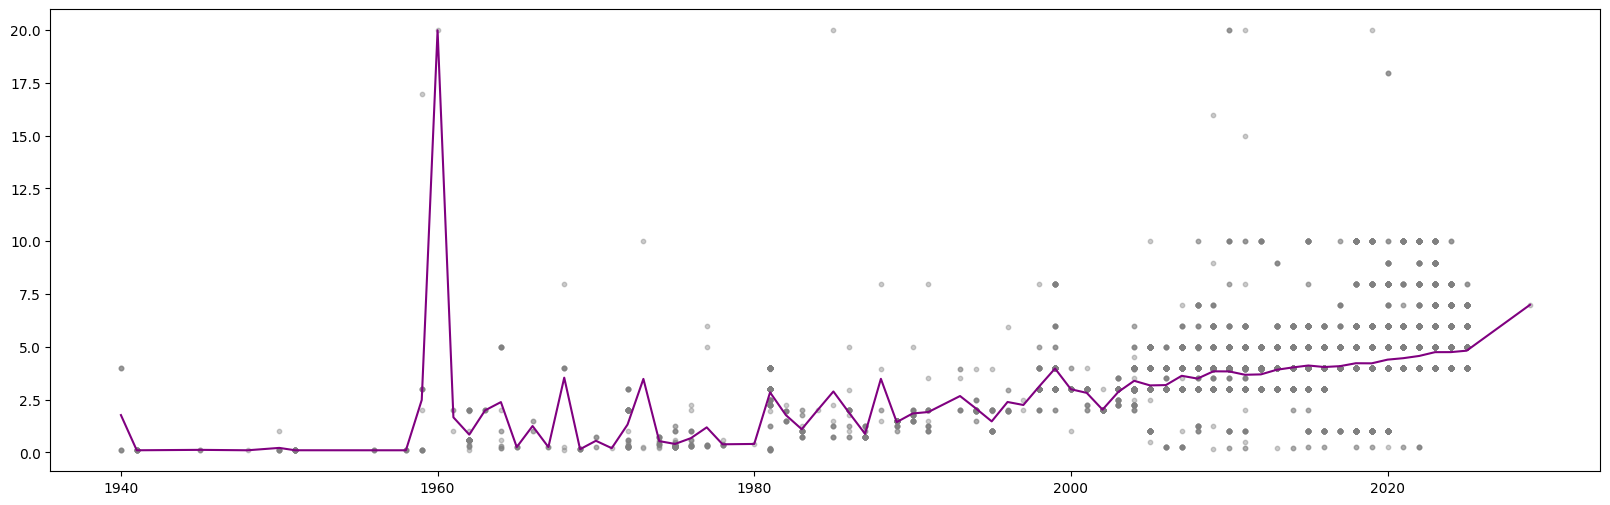

In [20]:
comics_average_price_over_time(dataComics, show_plot=True)

## INSIGHT 2 Comics: Média de páginas sobre o tempo

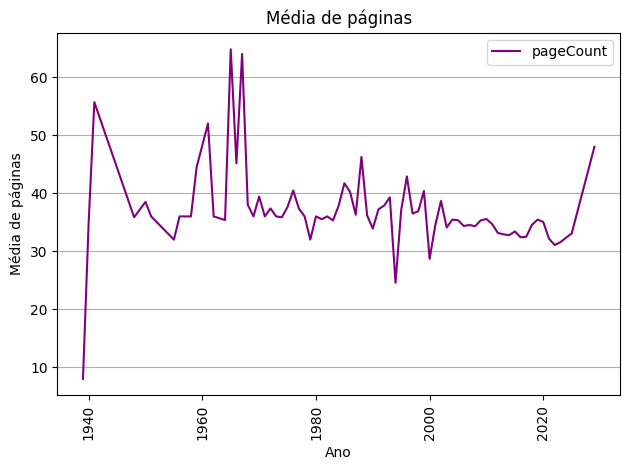

,pageCount
year,
1939.0,8.000000
1940.0,35.000000
1941.0,55.692308
1948.0,35.862069
1950.0,38.500000
...,...
2022.0,31.081812
2023.0,31.550000
2024.0,32.322906


In [21]:
comics_average_pages_over_time(dataComics, show_plot=True)

## INSIGHT 3 Comics: Os formatos mais comuns

In [22]:
comics_count_format(dataComics, show_plot=True)

,count
format,
Comic,52164
Trade Paperback,7116
Hardcover,1902
Digital Vertical Comic,1491
Digital Comic,782
Infinite Comic,269
Digest,203
Magazine,87
Poster,71


# Series

## INSIGHT 1 Series: Quantidade de issues lançadas por ano

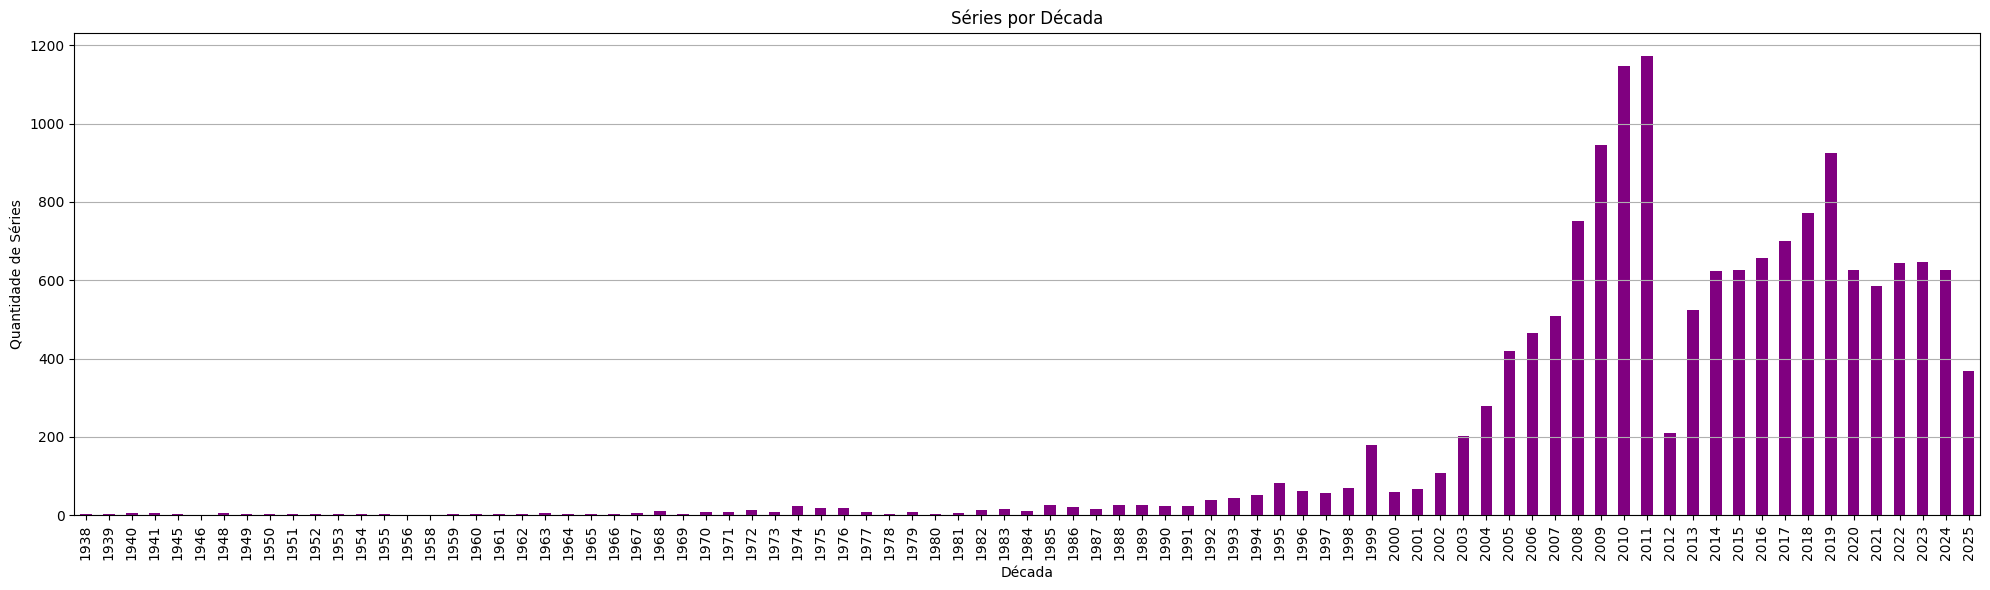

,count
startYear,
1938,4
1939,2
1940,5
1941,5
1945,2
...,...
2021,584
2022,645
2023,646


In [23]:
series_by_year(dataSeries, show_plot=True)

## INSIGHT 2 Series: Média da duração das series

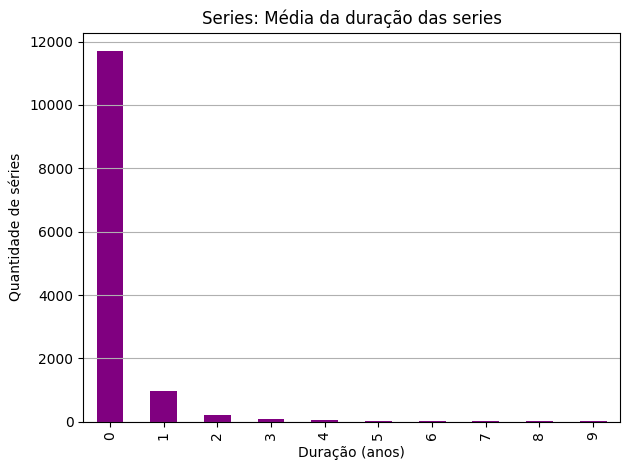

(duration
 0    11690
 1      959
 2      207
 3       80
 4       54
 5       18
 6       22
 7       13
 8       11
 9       15
 Name: count, dtype: int64,
 np.float64(0.28381053914102955))

In [24]:
series_average_duration(dataSeries, show_plot=True)

## INSIGHT 3 Series: Distribuição classificatória de faixa etária

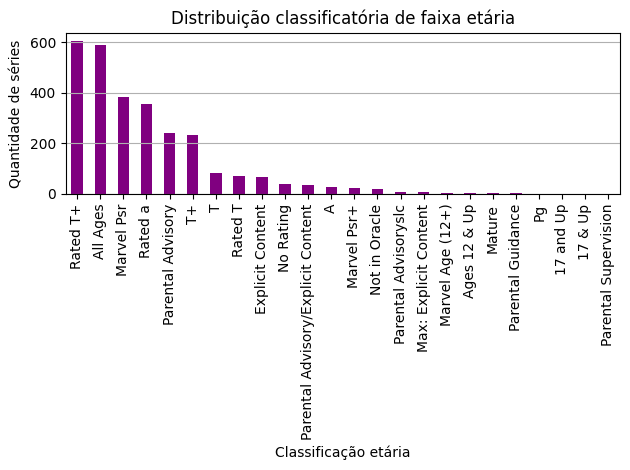

,count
rating,
Rated T+,606
All Ages,589
Marvel Psr,381
Rated a,354
Parental Advisory,239
T+,232
T,83
Rated T,69
Explicit Content,66


In [25]:
series_distribution_rating(dataSeries, show_plot=True)

## INSIGHT 4 Series: Distribuição dos tipos de séries

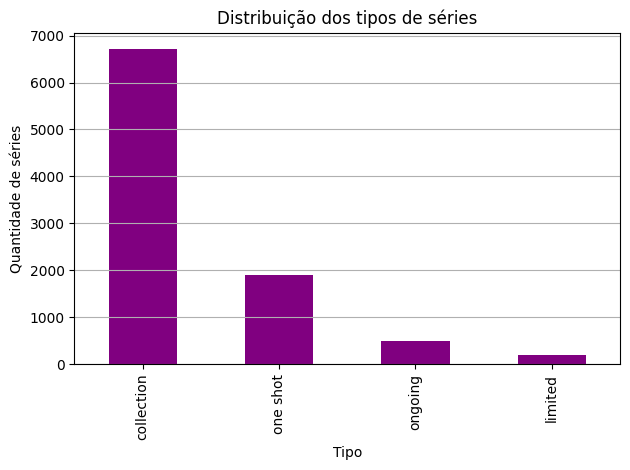

,count
type,
collection,6723
one shot,1897
ongoing,499
limited,204


In [26]:
series_distribuition_type(dataSeries, show_plot=True)

## INSIGHT 5 Series: Quantidade de personagens por ano

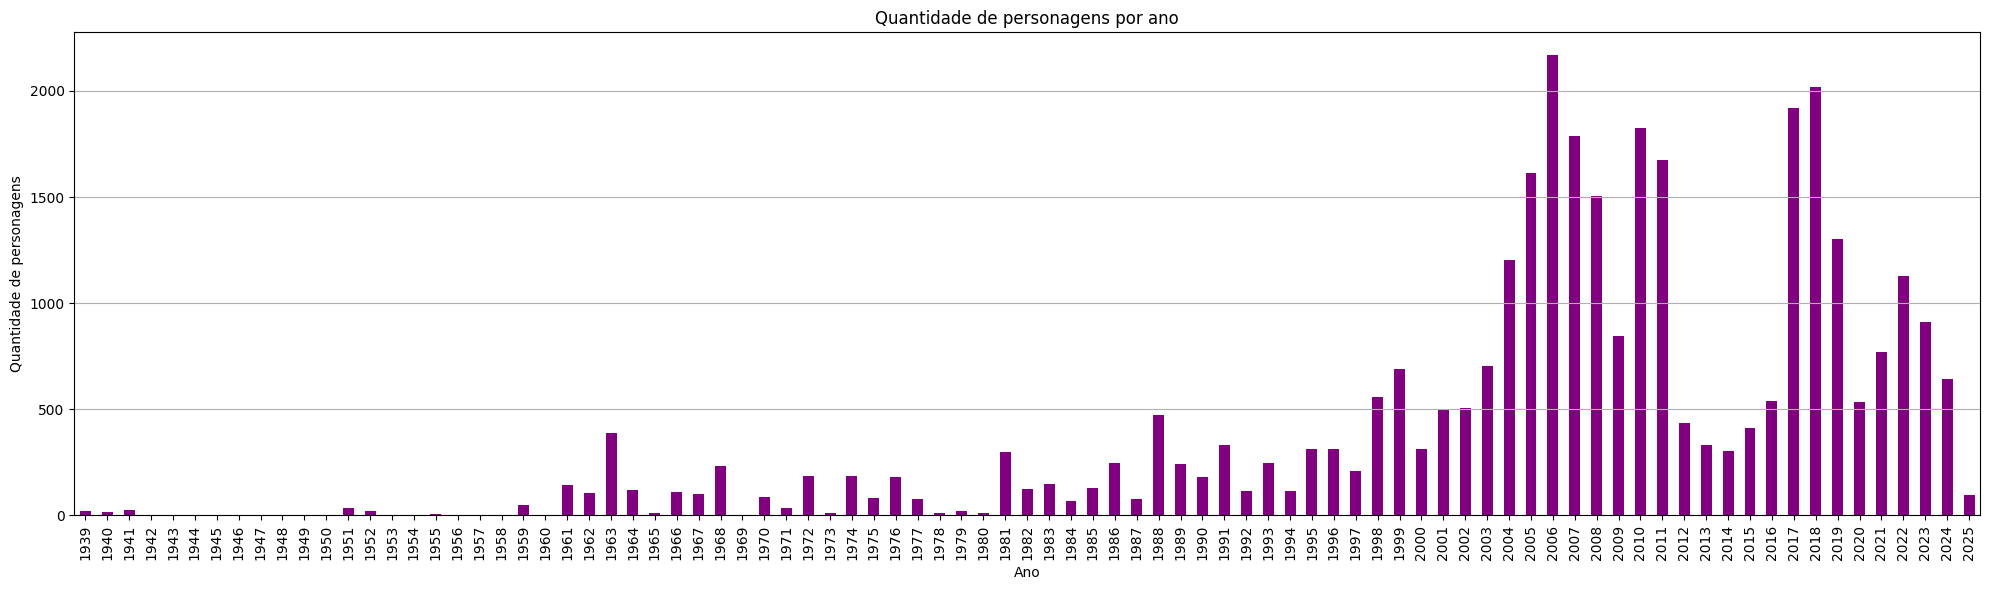

,0
1939,22.0
1940,13.0
1941,26.0
1942,0.0
1943,0.0
...,...
2021,771.0
2022,1128.0
2023,910.0
2024,644.0


In [27]:
series_quantity_characters_year(dataSeries, show_plot=True)

## Dados errados da API em relação a duração

In [28]:
duration = dataSeries['duration'].value_counts().sort_index()
dataSeries[(dataSeries['duration'] < 0) | (dataSeries['duration'] > 999)]

,id,title,description,startYear,endYear,rating,type,duration,creator_name,creator_qty,character_qty,story_qty,event_qty,comic_qty
3599,7734,Electric Ant (0000 - 2010),None,0,2010,,,2010,"Pascal Alixe, Lovern Kindzierski, Chris Sotoma...",8,0,39,0,6
3925,33956,Eternals: 500-Year War Infinity Comic (2029 - ...,"An international, all-star creative team of wr...",2029,2022,,,-7,"Geoffo, Dan Abnett, Yifan Jiang, David Macho, ...",21,0,14,0,7
4622,25304,GET FURY (2029 - 2024),None,2029,2024,,collection,-5,Jeff Youngquist,1,0,2,0,1
5990,5267,Iron Man: Director of S.H.I.E.L.D. (2008 - 2007),"Being one of the world's smartest, wealthiest ...",2008,2007,,,-1,"Vc Joe Caramagna, Sean Chen, Steve Kurth, Carl...",15,1,19,2,8
7712,14745,Marvel Super Stars Magazine (2011 - 2010),None,2011,2010,,,-1,Michael Turner,1,0,1,0,1
9094,13568,Official Handbook of the Ultimate Marvel Unive...,None,2010,2006,,,-4,"Various, Mark Bagley, Morry Hollowell, Stuart ...",4,4,7,0,4
9095,13567,Official Handbook of the Ultimate Marvel Unive...,None,2010,2006,,,-4,,0,0,0,0,0
9471,9932,Punisher Max: Tiny Ugly World (2013 - 2010),None,2013,2010,,,-3,"David Lapham, Dalibor Talajic",2,0,2,0,1
10160,3864,SHANNA THE SHE DEVIL: SURVIVAL OF THE FITTEST ...,None,2008,2007,Parental Advisory,,-1,,0,0,4,0,1
11375,20133,Star Wars: Boba Fett (1997 - 1996),None,1997,1996,,,-1,"Steve Dutro, Cam Kennedy, John Wagner",3,0,2,0,1


# Stories

## INSIGHT 1 Stories: Quantidade de cada tipo

In [29]:
types = stories_quantity_type(dataStories, show_plot=True)